## Setup datacube environment and ingest 1 year of Landsat data covering the state of Jalisco

In [ ]:
!createdb datacube_apolo
!datacube -v system init
!python /home/madmex_user/git/antares3/madmex.py conf_setup
!datacube -v product add ~/.config/madmex/indexing/landsat_8_espa_scenes.yaml
!python /home/madmex_user/git/antares3/madmex.py prepare_metadata -p /LUSTRE/MADMEX/staging/Jalisco-2017-L8/ -d landsat_espa -o ~/ls8_espa.yaml
!datacube -v dataset add ~/ls8_espa.yaml
!datacube ingest -c ~/.config/madmex/ingestion/ls8_espa_mexico.yaml --executor multiproc 7

## srtm ingestion

In [ ]:
!datacube -v product add ~/.config/madmex/indexing/srtm_cgiar.yaml
!python /home/madmex_user/git/antares3/madmex.py prepare_metadata -p /data/test_data/srtm/ -d srtm_cgiar -o ~/srtm.yaml
!datacube -v dataset add ~/srtm.yaml
!datacube ingest -c ~/.config/madmex/ingestion/srtm_cgiar_mexico.yaml

## Verify that the data have been ingested

In [11]:
import datacube
import matplotlib
%matplotlib inline
from datacube.storage import masking
import pandas
from datetime import datetime
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [14]:
dc = datacube.Datacube(app = 'jalisco')
dc.list_products()

sr = dc.load(product='ls8_espa_mexico', x=(-103.8, -103), y=(20.35, 20.86),
             time=(datetime(2017, 4, 1), datetime(2017, 8, 1)), group_by='solar_day',
             use_threads=True)
print(sr)
pandas.DataFrame.from_dict(masking.get_flags_def(sr.pixel_qa), orient='index')

<xarray.Dataset>
Dimensions:   (time: 16, x: 2787, y: 1913)
Coordinates:
  * time      (time) datetime64[ns] 2017-04-02T17:17:19.190333 ...
  * y         (y) float64 9.905e+05 9.905e+05 9.905e+05 9.904e+05 9.904e+05 ...
  * x         (x) float64 2.313e+06 2.313e+06 2.313e+06 2.313e+06 2.313e+06 ...
Data variables:
    blue      (time, y, x) int16 782 607 546 623 840 814 806 777 602 741 691 ...
    green     (time, y, x) int16 1085 835 712 882 1199 1189 1173 1148 911 ...
    red       (time, y, x) int16 1366 1126 979 1227 1668 1647 1627 1607 1141 ...
    nir       (time, y, x) int16 2604 2109 1855 2005 2507 2539 2539 2506 ...
    swir1     (time, y, x) int16 2734 2805 2442 2493 2759 2707 2650 2484 ...
    swir2     (time, y, x) int16 2046 1967 1721 1726 2054 2006 1990 1853 ...
    pixel_qa  (time, y, x) int16 322 322 322 322 322 322 322 322 322 322 322 ...
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...


,bits,values,description
clear,[1],"{'0': False, '1': True}",Clear
cloud,[5],"{'0': False, '1': True}",Cloud
cloud_confidence,"[8, 9]","{'0': 'none', '1': 'low', '3': 'high', '2': 'm...",Cirrus confidence
cloud_shadow,[3],"{'0': False, '1': True}",Cloud shadow
fill,[0],"{'0': False, '1': True}",Fill
snow,[4],"{'0': False, '1': True}",Snow
terrain_occlusion,[10],"{'0': False, '1': True}",Terrain occlusion
water,[2],"{'0': False, '1': True}",Water


## Build a cloud free ndvi composite

/home/madmex_user/.virtualenvs/antares/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


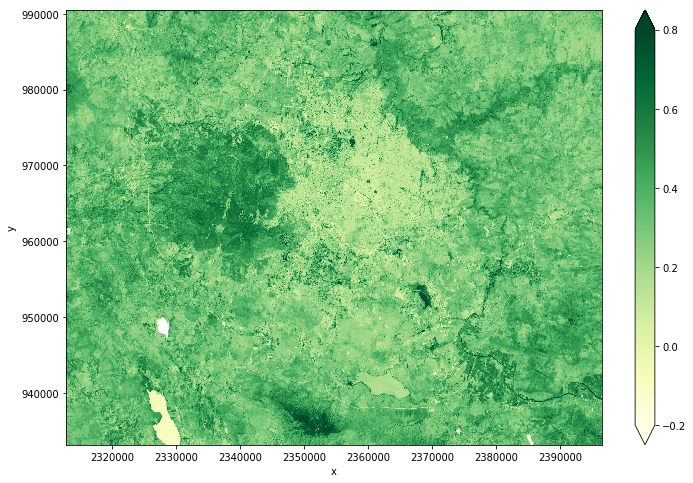

In [13]:
ndvi = (sr.nir - sr.red) / (sr.nir + sr.red)
clear = masking.make_mask(sr.pixel_qa, clear=True)
ndvi_clear = ndvi.where(clear)
ndvi_clear_mean = ndvi_clear.mean('time')
ndvi_clear_mean.plot(vmin=-0.2, vmax=0.8, cmap='YlGn')